In [19]:
import torch
import torch.nn as nn
import cv2
import os
import h5py
import numpy as np
from torch.utils.data import Dataset
import glob
import PIL.Image as pil_image
from utils import convert_rgb_to_y
import pywt
from skimage.metrics import structural_similarity as ssim

In [20]:
class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][idx] / 255., 0), np.expand_dims(f['hr'][idx] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])
        
class TrainWaveletDataset(Dataset):
    def __init__(self, h5_file,wavelet_type):
        super(TrainWaveletDataset, self).__init__()
        self.h5_file = h5_file
        self.wv_func = wavelet_type

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            
            coeffs = pywt.dwt2(f['lr'][idx] / 255,self.wv_func)
            LL, (LH, HL, HH) = coeffs
            h = LL.shape[0]
            w = LL.shape[1]
            lr_wave_coeffs = np.zeros((4,h,w),dtype=np.float32)
            lr_wave_coeffs[0] = LL
            lr_wave_coeffs[1] = LH
            lr_wave_coeffs[2] = HL
            lr_wave_coeffs[3] = HH
            
            coeffs = pywt.dwt2(f['hr'][idx] / 255,self.wv_func)
            LL, (LH, HL, HH) = coeffs
            hr_wave_coeffs = np.zeros((4,h,w),dtype=np.float32)
            hr_wave_coeffs[0] = LL
            hr_wave_coeffs[1] = LH
            hr_wave_coeffs[2] = HL
            hr_wave_coeffs[3] = HH
            
            return lr_wave_coeffs, hr_wave_coeffs-lr_wave_coeffs

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [21]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [22]:
class dwsr_modified(nn.Module):
    def __init__(self, num_channels=4):
        super(dwsr_modified, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=5 // 2)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=5, padding=5 // 2)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=5, padding=5 // 2)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv7 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.conv7(x)
        return x

In [23]:
class dwsr(nn.Module):
    def __init__(self, num_channels=4,num_layers=10):
        super(dwsr, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(num_channels, 64, kernel_size=3, padding=3 // 2))
        for i in range(num_layers):
            self.layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=3 // 2))
        self.layers.append(nn.Conv2d(64, num_channels, kernel_size=3, padding=3 // 2))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        for mylayer in self.layers[0:-1]:
            x = self.relu(mylayer(x))
        x = self.layers[-1](x)
        return x    
    

In [24]:
import copy
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

from utils import AverageMeter, calc_psnr

train_file = 'data.h5'
scale = 2
batch_size = 16
num_epochs = 2
outputs_dir = 'output'
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)

model = dwsr_modified().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

wavelet_type = 'haar'
train_dataset = TrainWaveletDataset(train_file,wavelet_type)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=8,
                              pin_memory=True,
                              drop_last=True)

In [25]:
for epoch in range(num_epochs):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))

        for data in train_dataloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    #torch.save(model.state_dict(), os.path.join(args.outputs_dir, 'epoch_{}.pth'.format(epoch)))

#     model.eval()
#     epoch_psnr = AverageMeter()

#     for data in eval_dataloader:
#         inputs, labels = data

#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         with torch.no_grad():
#             preds = model(inputs).clamp(0.0, 1.0)

#         epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

#     print('eval psnr: {:.2f}'.format(epoch_psnr.avg))

#     if epoch_psnr.avg > best_psnr:
#         best_epoch = epoch
#         best_psnr = epoch_psnr.avg
#         best_weights = copy.deepcopy(model.state_dict())

#print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
#torch.save(best_weights, os.path.join(args.outputs_dir, 'best.pth'))

epoch: 1/1: 100%|██████████| 70144/70144 [00:37<00:00, 1864.28it/s, loss=0.000760]


In [26]:
def create_coeff_matrix(img,wavelet_type):
    coeffs = pywt.dwt2(img,wavelet_type)
    LL, (LH, HL, HH) = coeffs
    h = LL.shape[0]
    w = LL.shape[1]
    lr_wave_coeffs = np.zeros((4,h,w),dtype=np.float32)
    lr_wave_coeffs[0] = LL
    lr_wave_coeffs[1] = LH
    lr_wave_coeffs[2] = HL
    lr_wave_coeffs[3] = HH
    return lr_wave_coeffs

def create_img(coeffs_matrix,wavelet_type):
    out = pywt.idwt2((coeffs_matrix[0],(coeffs_matrix[1],coeffs_matrix[2],coeffs_matrix[3])), wavelet_type)
    return out

In [83]:
hr = pil_image.open('chest_xray_data/154.jpg').convert('RGB')
hr_width = (hr.width // scale) * scale
hr_height = (hr.height // scale) * scale
hr = hr.resize((hr_width, hr_height), resample=pil_image.BICUBIC)
lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
hr = np.array(hr).astype(np.float32)
lr = np.array(lr).astype(np.float32)
hr = convert_rgb_to_y(hr)/255.
lr = convert_rgb_to_y(lr)/255.
lr_coeffs = create_coeff_matrix(lr,wavelet_type)

In [10]:
psnr_vals = []
ssim_vals = []
for i in range(250):
    hr = pil_image.open('chest_xray_data/'+str(i)+'.jpg').convert('RGB')
    hr_width = (hr.width // scale) * scale
    hr_height = (hr.height // scale) * scale
    hr = hr.resize((hr_width, hr_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
    lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    hr = np.array(hr).astype(np.float32)
    lr = np.array(lr).astype(np.float32)
    hr = convert_rgb_to_y(hr)/255.
    lr = convert_rgb_to_y(lr)/255.
    lr_coeffs = create_coeff_matrix(lr,wavelet_type)    
    inp = torch.from_numpy(lr_coeffs).unsqueeze(0).to(device)
    #target = torch.from_numpy(hr).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        preds = model(inp)
    coeffs_matrix = preds.squeeze(0).cpu().numpy()+lr_coeffs
    high_res_image_gen = create_img(coeffs_matrix,wavelet_type)
    psnr_val = 10. * np.log10(1. / np.mean((hr - high_res_image_gen) ** 2))
    ssim_val = ssim(hr,high_res_image_gen)
    psnr_vals.append(psnr_val)
    ssim_vals.append(ssim_val)

In [12]:
np.mean(ssim_vals)

0.9611211431719334

In [84]:
#inp = torch.from_numpy(lr).unsqueeze(0).unsqueeze(0).to(device)
inp = torch.from_numpy(lr_coeffs).unsqueeze(0).to(device)
#target = torch.from_numpy(hr).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    preds = model(inp)

In [85]:
coeffs_matrix = preds.squeeze(0).cpu().numpy()+lr_coeffs
high_res_image_gen = create_img(coeffs_matrix,wavelet_type)
#high_res_image_gen = preds.squeeze(0).squeeze(0).cpu().numpy()

In [86]:
psnr_val = 10. * np.log10(1. / np.mean((hr - high_res_image_gen) ** 2))

Value of psnr is 42.092858


0.9887580265420222

<Figure size 432x288 with 0 Axes>

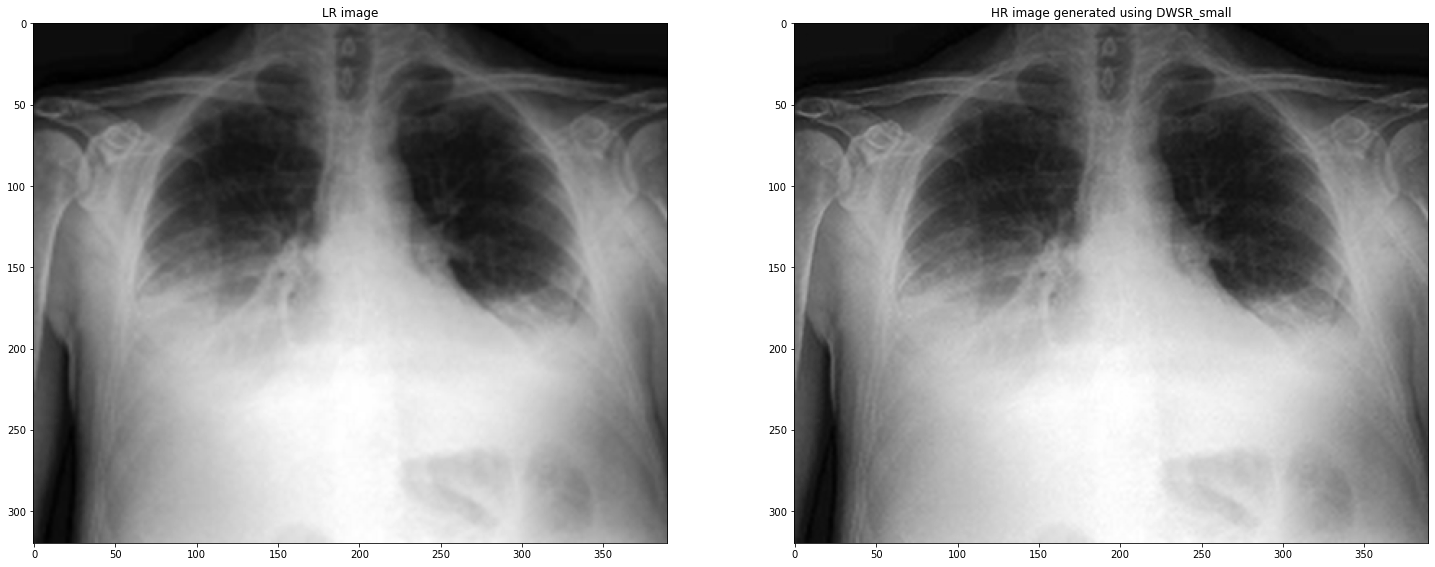

In [87]:
import matplotlib.pyplot as plt
plt.gray()
axes=[]
fig=plt.figure(figsize=(25,25))

axes.append(fig.add_subplot(1,2,1))
subplot_title=("LR image")
axes[-1].set_title(subplot_title)
plt.imshow(lr)

# axes.append(fig.add_subplot(1,3,2))
# subplot_title=("Actual HR image")
# axes[-1].set_title(subplot_title)
# plt.imshow(hr)

axes.append(fig.add_subplot(1,2,2))
subplot_title=("HR image generated using DWSR_small")
axes[-1].set_title(subplot_title)
plt.imshow(high_res_image_gen)
print("Value of psnr is %f"%(psnr_val))
ssim(hr,high_res_image_gen)

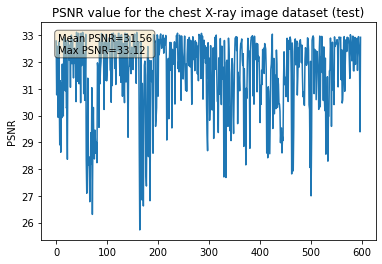

In [266]:
fig, ax = plt.subplots()

avg = np.mean(psnr_vals)
m = np.max(psnr_vals)
textstr = '\n'.join((
    r'Mean PSNR=%.2f' % (avg, ),
    r'Max PSNR=%.2f' % (m, )))

ax.plot(psnr_vals)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.ylabel('PSNR')
plt.title('PSNR value for the chest X-ray image dataset (test)')
plt.show()

In [10]:
import matplotlib.pyplot as plt
import scipy

In [9]:
images_dir = 'Widy_applied_NUC'
psnr_vals = []
ssim_vals = []

In [11]:
for image_path in sorted(glob.glob('{}/*'.format(images_dir))):
    hr = plt.imread(image_path)
    hr = hr/max(np.amax(hr,1))
    lr = scipy.ndimage.zoom(hr, 0.5, order=3)
    lr = scipy.ndimage.zoom(lr, 2, order=3)
    lr = lr/max(np.amax(lr,1))
    hr = np.array(hr).astype(np.float32)
    lr = np.array(lr).astype(np.float32)
    lr_coeffs = create_coeff_matrix(lr,wavelet_type)
    
    inp = torch.from_numpy(lr_coeffs).unsqueeze(0).to(device)
    #target = torch.from_numpy(hr).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        preds = model(inp)
    coeffs_matrix = preds.squeeze(0).cpu().numpy()+lr_coeffs
    high_res_image_gen = create_img(coeffs_matrix,wavelet_type)
    psnr_val = 10. * np.log10(1. / np.mean((hr - high_res_image_gen) ** 2))
    ssim_val = ssim(hr,high_res_image_gen)
    psnr_vals.append(psnr_val)
    ssim_vals.append(ssim_val)

In [13]:
np.mean(psnr_vals)

31.389288255052964

In [74]:
hr = plt.imread('Widy_applied_NUC/Widy_5000us_NUC_232.tif')
hr = hr/max(np.amax(hr,1))
lr = scipy.ndimage.zoom(hr, 0.5, order=3)
lr = scipy.ndimage.zoom(lr, 2, order=3)
lr = lr/max(np.amax(lr,1))
hr = np.array(hr).astype(np.float32)
lr = np.array(lr).astype(np.float32)
lr_coeffs = create_coeff_matrix(lr,'bior1.3')

inp = torch.from_numpy(lr_coeffs).unsqueeze(0).to(device)
#target = torch.from_numpy(hr).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    preds = model(inp)
coeffs_matrix = preds.squeeze(0).cpu().numpy()+lr_coeffs
high_res_image_gen = create_img(coeffs_matrix,'bior1.3')
psnr_val = 10. * np.log10(1. / np.mean((hr - high_res_image_gen) ** 2))

In [75]:
psnr_val

32.56701260164317

In [14]:
images_dir = 'natural_img_test'
psnr_vals = []
ssim_vals = []
for image_path in sorted(glob.glob('{}/*'.format(images_dir))):
    hr = pil_image.open(image_path).convert('RGB')
    hr_width = (hr.width // scale) * scale
    hr_height = (hr.height // scale) * scale
    hr = hr.resize((hr_width, hr_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
    lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    hr = np.array(hr).astype(np.float32)
    lr = np.array(lr).astype(np.float32)
    hr = convert_rgb_to_y(hr)/255.
    lr = convert_rgb_to_y(lr)/255.
    lr_coeffs = create_coeff_matrix(lr,wavelet_type)    
    inp = torch.from_numpy(lr_coeffs).unsqueeze(0).to(device)
    #target = torch.from_numpy(hr).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        preds = model(inp)
    coeffs_matrix = preds.squeeze(0).cpu().numpy()+lr_coeffs
    high_res_image_gen = create_img(coeffs_matrix,wavelet_type)
    psnr_val = 10. * np.log10(1. / np.mean((hr - high_res_image_gen) ** 2))
    ssim_val = ssim(hr,high_res_image_gen)
    psnr_vals.append(psnr_val)
    ssim_vals.append(ssim_val)

In [16]:
np.mean(ssim_vals)

0.9578042321066931